In [1]:
#@title MIT License
#
# Copyright (c) 2019 Andreas Eberlein
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Train a deep neural network for semantic segmentation based on Virtual KITTI dataset

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics


import cv2
import pickle
import h5py

In [3]:
import data_helper

In [4]:
processed_training_data_file_name = "../Data_compressed/Preprocessed/ProcessedTrainingData.hdf5"

data_file = h5py.File(processed_training_data_file_name, 'r')

one_hot_encoded_labels = data_file['one_hot_encoded_labels']
train_images = data_file['training_images']

In [5]:
# Briefly check whether reimport of data worked out
print(one_hot_encoded_labels.shape)
print(train_images.shape)

(447, 125, 414, 14)
(447, 125, 414, 3)


In [6]:
dict_file_name = '../Data_compressed/Preprocessed/Dictionaries.dat'
dict_file = open(dict_file_name, 'rb')
value_category_id_mappings = pickle.load(dict_file)
dict_file.close()
values_categories_dict, categories_ids_dict, ids_categories_dict, \
            ids_values_dict, values_ids_dict = value_category_id_mappings
print(categories_ids_dict)
print(ids_values_dict)

{'GuardRail': 0, 'Terrain': 1, 'Car': 2, 'Pole': 3, 'Vegetation': 4, 'Truck': 5, 'TrafficSign': 6, 'Sky': 7, 'TrafficLight': 8, 'Misc': 9, 'Van': 10, 'Road': 11, 'Building': 12, 'Tree': 13}
{0: (255, 100, 255), 1: (210, 0, 200), 2: (200, 200, 200), 3: (255, 130, 0), 4: (90, 240, 0), 5: (160, 60, 60), 6: (255, 255, 0), 7: (90, 200, 255), 8: (200, 200, 0), 9: (80, 80, 80), 10: (230, 208, 202), 11: (100, 60, 100), 12: (140, 140, 140), 13: (0, 199, 0)}


In [7]:
# Now we reconstruct a few label images from one-hot encoding to colour coding for testing purposes
decoded_labels = data_helper.oneHotDecodeImages(one_hot_encoded_labels[0:4], ids_values_dict)

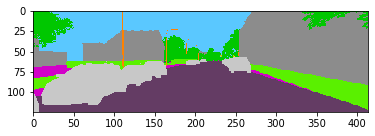

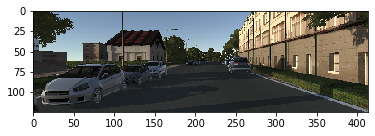

In [8]:
data_helper.plot_as_rgb_image(decoded_labels[0])
plt.show()
data_helper.plot_as_rgb_image(train_images[0])
plt.show()

## Setting model and training parameters

In [9]:
batch_size = 8
epochs = 50
img_shape = train_images[0].shape
img_shape

(125, 414, 3)

## Define model
The stated results for quality metrics are for `batch_size = 8`, `epochs = 50` and `160` training images.

In [10]:
def simpleBottleneckModel():
    #           loss         acc   mean_io_u    val_loss     val_acc    val_mean_io_u
    # 49    0.060444    0.583671    0.516185    0.062567    0.566679    0.508713
    model = models.Sequential()
    model.add(layers.Conv2D(12, 3, padding='same', activation='relu', input_shape=img_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(24, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.ZeroPadding2D(padding=((0,0), (0,1))))
    model.add(layers.Conv2D(24, 3, padding='same', activation='relu'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.ZeroPadding2D(padding=((1,0), (0,0))))
    model.add(layers.Conv2D(24, 3, padding='same', activation='relu'))
    model.add(layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', activation=activations.softmax))
    
    return model

def simpleFCN():
    #           loss         acc   mean_io_u    val_loss     val_acc    val_mean_io_u
    # 49    0.072745    0.492963    0.548216    0.082275    0.424431    0.519200
    # Computationally more heavy than simpleBottleneckModel and less accurate. Seems to capture more details
    # in images, but not necessarily their correct class.
    model = models.Sequential()
    model.add(layers.Conv2D(6, 12, padding='same', activation='relu', input_shape=img_shape))
    model.add(layers.Conv2D(12, 8, padding='same', activation='relu'))
    model.add(layers.Conv2D(24, 6, padding='same', activation='relu'))
    model.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
    model.add(layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', activation=activations.softmax))
    
    return model

def bottleneckWithSkipLayerModel():
    #           loss         acc   mean_io_u    val_loss     val_acc    val_mean_io_u
    # 49    0.056245    0.612250    0.562411    0.058371    0.598306    0.552687    Trained with 160 images
    # 49    0.069816    0.512127    0.563289    0.071772    0.498191    0.565212    Trained with 320 images
    inputs = layers.Input(shape=img_shape)
    conv1 = layers.Conv2D(12, 3, padding='same', activation='relu')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(24, 3, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(48, 3, padding='same', activation='relu')(pool2)
    upsampl1 = layers.UpSampling2D(size=(2,2))(conv3)
    padd1 = layers.ZeroPadding2D(padding=((0,0), (0,1)))(upsampl1)
    conv4 = layers.Conv2D(24, 3, padding='same', activation='relu')(padd1)
    concat1 = layers.concatenate([conv2, conv4], axis=-1)
    conv5 = layers.Conv2D(48, 3, padding='same', activation='relu')(concat1)
    upsampl2 = layers.UpSampling2D(size=(2,2))(conv5)
    padd2 = layers.ZeroPadding2D(padding=((1,0), (0,0)))(upsampl2)
    conv6 = layers.Conv2D(24, 3, padding='same', activation='relu')(padd2)
    predictions = layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', 
                                activation=activations.softmax)(conv6)
        
    return models.Model(inputs=inputs, outputs=predictions)

def bottleneckModelWithSkipLayers():
    #           loss         acc   mean_io_u    val_loss     val_acc    val_mean_io_u
    # 49    0.060510    0.579252    0.612366    0.067015    0.533291    0.588853    Trained with 160 images
    inputs = layers.Input(shape=img_shape)
    conv1 = layers.Conv2D(12, 3, padding='same', activation='relu')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(24, 3, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(48, 3, padding='same', activation='relu')(pool2)
    upsampl1 = layers.UpSampling2D(size=(2,2))(conv3)
    padd1 = layers.ZeroPadding2D(padding=((0,0), (0,1)))(upsampl1)
    conv4 = layers.Conv2D(24, 3, padding='same', activation='relu')(padd1)
    concat1 = layers.Concatenate(axis=-1)([conv2, conv4])
    conv5 = layers.Conv2D(48, 3, padding='same', activation='relu')(concat1)
    upsampl2 = layers.UpSampling2D(size=(2,2))(conv5)
    padd2 = layers.ZeroPadding2D(padding=((1,0), (0,0)))(upsampl2)
    conv6 = layers.Conv2D(24, 3, padding='same', activation='relu')(padd2)
    concat2 = layers.Concatenate(axis=-1)([conv1, conv6])
    conv7 = layers.Conv2D(24, 5, padding='same', activation='relu')(concat2)
    predictions = layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', 
                                activation=activations.softmax)(conv7)
        
    return models.Model(inputs=inputs, outputs=predictions)

model = bottleneckModelWithSkipLayers()

W0714 22:16:04.466827 139963385833280 deprecation.py:506] From /home/andreas/Programmieren_MachineLearning/anaconda3/envs/VirtualKITTI/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
learn_rate = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=learn_rate)

model.compile(optimizer=optimizer,
              loss=losses.mean_absolute_error,
              metrics=['accuracy', metrics.MeanIoU(num_classes=one_hot_encoded_labels.shape[3])]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 414, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 414, 12) 336         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 207, 12)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 207, 24)  2616        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [12]:
history = model.fit(train_images[0:160], one_hot_encoded_labels[0:160], epochs=epochs,
                   validation_split=0.2, verbose=1)
# history = model.fit(train_images[0:10], one_hot_encoded_labels[0:10], epochs=2,
#                    validation_split=0.2, verbose=1)

Train on 128 samples, validate on 32 samples
Epoch 1/50
128/128 [==============================] - 60s 465ms/sample - loss: 0.1377 - acc: 0.0364 - mean_io_u: 0.4481 - val_loss: 0.1351 - val_acc: 0.0540 - val_mean_io_u: 0.4619
Epoch 2/50
128/128 [==============================] - 59s 458ms/sample - loss: 0.1226 - acc: 0.1424 - mean_io_u: 0.4740 - val_loss: 0.1209 - val_acc: 0.1536 - val_mean_io_u: 0.4783
Epoch 3/50
128/128 [==============================] - 59s 464ms/sample - loss: 0.1128 - acc: 0.2106 - mean_io_u: 0.4969 - val_loss: 0.1208 - val_acc: 0.1546 - val_mean_io_u: 0.4837
Epoch 4/50
128/128 [==============================] - 57s 448ms/sample - loss: 0.1126 - acc: 0.2116 - mean_io_u: 0.5034 - val_loss: 0.1207 - val_acc: 0.1549 - val_mean_io_u: 0.4854
Epoch 5/50
128/128 [==============================] - 57s 448ms/sample - loss: 0.1126 - acc: 0.2119 - mean_io_u: 0.5053 - val_loss: 0.1207 - val_acc: 0.1550 - val_mean_io_u: 0.4853
Epoch 6/50
128/128 [==============================

Epoch 46/50
128/128 [==============================] - 59s 460ms/sample - loss: 0.0596 - acc: 0.5870 - mean_io_u: 0.5958 - val_loss: 0.0687 - val_acc: 0.5221 - val_mean_io_u: 0.5794
Epoch 47/50
128/128 [==============================] - 58s 452ms/sample - loss: 0.0592 - acc: 0.5883 - mean_io_u: 0.5991 - val_loss: 0.0718 - val_acc: 0.4964 - val_mean_io_u: 0.5802
Epoch 48/50
128/128 [==============================] - 58s 452ms/sample - loss: 0.0628 - acc: 0.5615 - mean_io_u: 0.6005 - val_loss: 0.0689 - val_acc: 0.5225 - val_mean_io_u: 0.5819
Epoch 49/50
128/128 [==============================] - 58s 456ms/sample - loss: 0.0600 - acc: 0.5832 - mean_io_u: 0.6041 - val_loss: 0.0752 - val_acc: 0.4764 - val_mean_io_u: 0.5745
Epoch 50/50
128/128 [==============================] - 59s 462ms/sample - loss: 0.0605 - acc: 0.5793 - mean_io_u: 0.6124 - val_loss: 0.0670 - val_acc: 0.5333 - val_mean_io_u: 0.5889


In [13]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist.tail()

,loss,acc,mean_io_u,val_loss,val_acc,val_mean_io_u
45,0.059559,0.586978,0.595836,0.068743,0.522141,0.579356
46,0.059246,0.588317,0.599109,0.071804,0.496407,0.580223
47,0.062778,0.561528,0.600549,0.068855,0.522485,0.581924
48,0.059954,0.583156,0.604142,0.075190,0.476417,0.574483
49,0.060510,0.579252,0.612366,0.067015,0.533291,0.588853


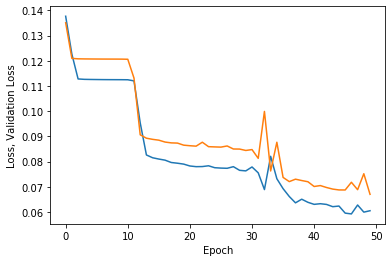

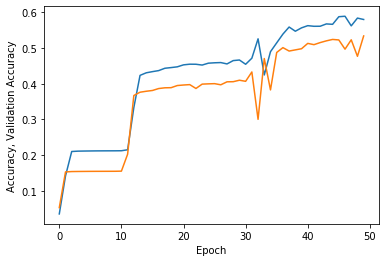

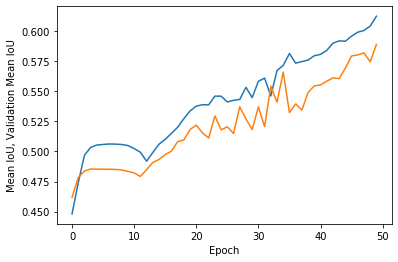

In [14]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss, Validation Loss')
plt.plot(hist['loss'], label='Loss')
plt.plot(hist['val_loss'], label='Val Loss')

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy, Validation Accuracy')
plt.plot(hist['acc'], label='Acc')
plt.plot(hist['val_acc'], label='Val Acc')

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean IoU, Validation Mean IoU')
plt.plot(hist['mean_io_u'], label='Mean IoU')
plt.plot(hist['val_mean_io_u'], label='Val Mean IoU')

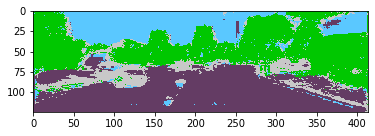

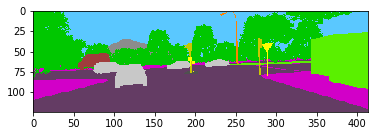

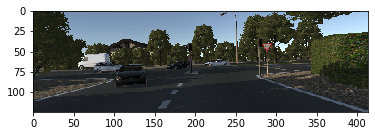

In [15]:
test_prediction = model.predict(train_images[-4:])
test_prediction_decoded = data_helper.oneHotDecodeImages(test_prediction, ids_values_dict)
ground_truth_decoded = data_helper.oneHotDecodeImages(one_hot_encoded_labels[-4:], ids_values_dict)

data_helper.plot_as_rgb_image(test_prediction_decoded[-2])
plt.show()
data_helper.plot_as_rgb_image(ground_truth_decoded[-2])
plt.show()
data_helper.plot_as_rgb_image(train_images[-2])
plt.show()

In [ ]:
data_file.close()

## To do:

- Find better loss function?
- Find more useful quality metrics?
- Look for paper on semantic segmentation for embedded platforms!